| Column Name         | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| Rater_1             | Identifier for the first rater                                              |
| Overall_1           | Holistic proficiency score                                                  |
| Cohesion_1          | Score for cohesion (logical flow and natural transitions)                   |
| Syntax_1            | Score for syntactic structure (sentence complexity and variety)             |
| Vocabulary_1        | Score for vocabulary (range, precision, and sophistication)                 |
| Phraseology_1       | Score for phraseology (use of collocations and idiomatic expressions)       |
| Grammar_1           | Score for grammatical accuracy (e.g., subject-verb agreement, tense usage)  |
| Conventions_1       | Score for conventions (spelling, punctuation, paragraph formatting)         |
| Identifying_Info_1  | Whether identifying information (e.g., real names) is included (should be 0)|

| Column Name         | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| Rater_2             | Identifier for the second rater                                             |
| Overall_2           | Holistic proficiency score                                                  |
| Cohesion_2          | Score for cohesion (logical flow and natural transitions)                   |
| Syntax_2            | Score for syntactic structure (sentence complexity and variety)             |
| Vocabulary_2        | Score for vocabulary (range, precision, and sophistication)                 |
| Phraseology_2       | Score for phraseology (use of collocations and idiomatic expressions)       |
| Grammar_2           | Score for grammatical accuracy (e.g., subject-verb agreement, tense usage)  |
| Conventions_2       | Score for conventions (spelling, punctuation, paragraph formatting)         |
| Identifying_Info_2  | Whether identifying information is included (should be 0)                   |


In [1]:
import pandas as pd
df = pd.read_csv("/kaggle/input/lang-data/ellipsis_raw_rater_scores_anon_all_essay.csv")
df.head()

,Filename,Text,Rater_1,Overall_1,Cohesion_1,Syntax_1,Vocabulary_1,Phraseology_1,Grammar_1,Conventions_1,Identifying_Info_1,Rater_2,Overall_2,Cohesion_2,Syntax_2,Vocabulary_2,Phraseology_2,Grammar_2,Conventions_2,Identifying_Info_2
0,2021000071.txt,"To the Principal,\r\n\r\nI think that policy 1...",rater_1,3,3,4,4,4,5,3,0,rater_2,3,4,3,3,3,3,3,0
1,2021000501.txt,"Dear, TEACHER_NAME\r\n\r\nI think phone policy...",rater_1,3,3,2,3,3,3,2,0,rater_2,3,4,3,4,3,4,3,0
2,2021000535.txt,"Dear, Principal\r\n\r\nIn my opinion, I think ...",rater_1,3,2,3,2,2,3,3,0,rater_2,3,3,3,4,3,3,4,0
3,2021000667.txt,PHONES\r\n\r\nDear principal students should h...,rater_1,3,2,3,3,3,3,3,0,rater_2,3,3,3,3,3,4,3,0
4,2021000683.txt,phones\r\n\r\ni think phones should be allowed...,rater_1,3,2,3,3,3,3,3,0,rater_2,3,2,2,3,3,3,2,0


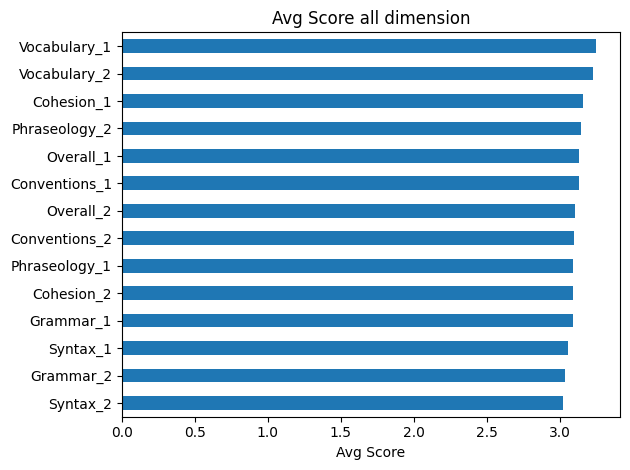

In [2]:
import matplotlib.pyplot as plt

# 取出所有维度评分（两位评分人）
score_columns = [col for col in df.columns if any(metric in col for metric in ['Overall', 'Cohesion', 'Syntax', 'Vocabulary', 'Phraseology', 'Grammar', 'Conventions'])]

df[score_columns].mean().sort_values().plot(kind='barh', title="Avg Score all dimension")
plt.xlabel("Avg Score")
plt.tight_layout()
plt.show()


Difference（Overall）: 0.5034870641169854


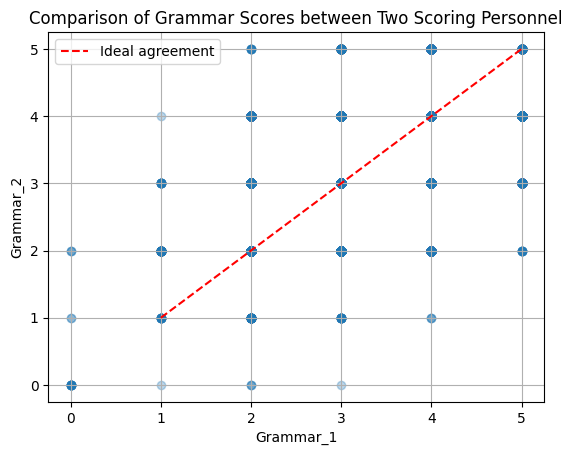

In [3]:
df['Overall_diff'] = abs(df['Overall_1'] - df['Overall_2'])
df['Grammar_diff'] = abs(df['Grammar_1'] - df['Grammar_2'])
print("Difference（Overall）:", df['Overall_diff'].mean())

plt.scatter(df['Grammar_1'], df['Grammar_2'], alpha=0.3)
plt.xlabel('Grammar_1')
plt.ylabel('Grammar_2')
plt.title('Comparison of Grammar Scores between Two Scoring Personnel')


plt.grid(True)
plt.plot([1, 5], [1, 5], 'r--', label='Ideal agreement')
plt.legend()
plt.show()

In [4]:
pearson_corr = df['Grammar_1'].corr(df['Grammar_2'], method='pearson')
print(pearson_corr)

0.4762122254527381


Overall_diff ≈ 0.5 → 表明评分员之间整体一致性不错；若用于训练机器评分模型，这样的数据是可靠的；
若进一步验证一致性，也可以用：
Pearson相关系数（连续评分一致性）
The 0.476 obtained belongs to the medium level of correlation, which indicates that: 
The two raters' overall judgment on the Grammar item was consistent. 
However, there are also some cases where there are disagreements or differences in style regarding the scoring. 
For research or automatic scoring modeling, this level of consistency is basically acceptable, but there is still room for improvement.

Represent the text using methods such as TF-IDF and sentence vectors, conduct cluster analysis, and observe whether there is a correlation with scores or writing styles.

For essays written by non-native speakers, investigate the correlation between different text styles and scores.

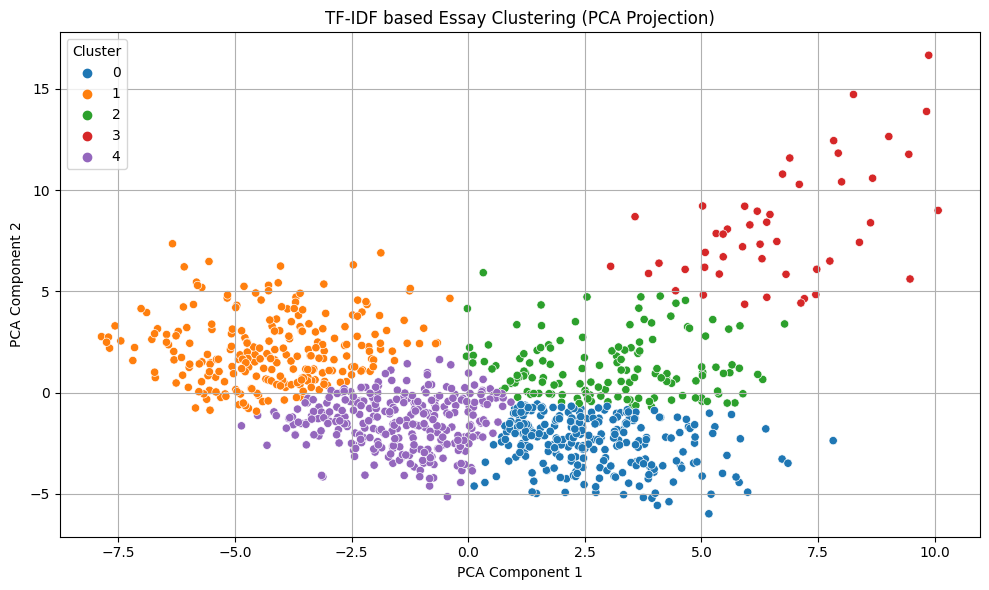

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Sample a manageable subset for clustering (e.g., 1000 essays)
sample_df = df.sample(n=1000, random_state=42).reset_index(drop=True)

# Use TF-IDF to vectorize the essay text
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(sample_df['Text'])

# Standardize the data before clustering
scaled_data = StandardScaler(with_mean=False).fit_transform(tfidf_matrix)

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(scaled_data.toarray())

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
sample_df['Cluster'] = kmeans.fit_predict(pca_result)

# Add PCA result for plotting
sample_df['PCA1'] = pca_result[:, 0]
sample_df['PCA2'] = pca_result[:, 1]

# Plot PCA result colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title("TF-IDF based Essay Clustering (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

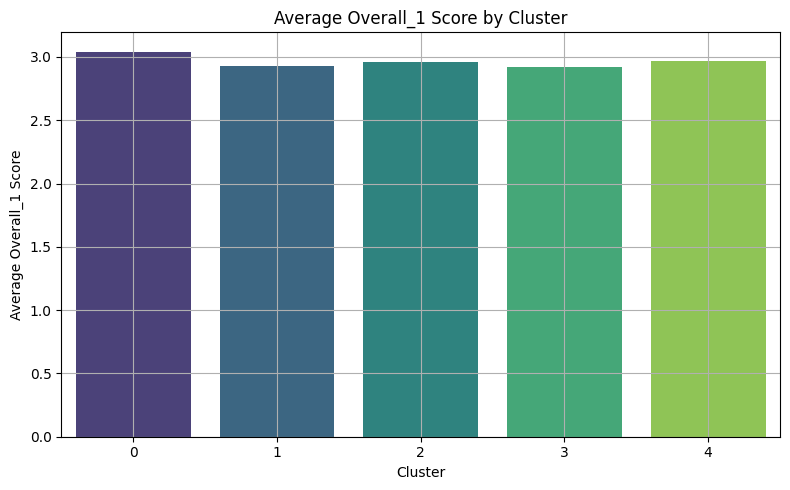

In [6]:
# Calculate the average Overall_1 score per cluster
sample_df['Overall_1'] = df.loc[sample_df.index, 'Overall_1'].values
cluster_scores = sample_df.groupby('Cluster')['Overall_1'].mean().reset_index()

# Plot average score per cluster
plt.figure(figsize=(8, 5))
sns.barplot(data=cluster_scores, x='Cluster', y='Overall_1', palette='viridis')
plt.title("Average Overall_1 Score by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Overall_1 Score")
plt.grid(True)
plt.tight_layout()
plt.show()

观察与初步结论
某些聚类（如 Cluster 2 和 Cluster 4）整体得分较高，可能代表写作规范、语言流畅、词汇丰富的作文。
而像 Cluster 0 的平均分明显偏低，可能包含语法较弱、结构混乱或词汇使用简单的作文。
聚类与得分之间存在一定关联性，说明 写作风格（基于TF-IDF表示）对评分有较强的解释力。

Observation and Preliminary Conclusion
Some clusters (such as Cluster 2 and Cluster 4) have relatively high overall scores, which might indicate well-written compositions with proper grammar, fluent language and rich vocabulary. 
However, the average score of Cluster 0 is significantly lower. This might be due to essays with weak grammar, chaotic structure or simple vocabulary usage. 
There is a certain correlation between clustering and scoring, indicating that the writing style (represented by TF-IDF) has a strong explanatory power for the scores.

观察与初步结论
某些聚类（如 Cluster 2 和 Cluster 4）整体得分较高，可能代表写作规范、语言流畅、词汇丰富的作文。

而像 Cluster 0 的平均分明显偏低，可能包含语法较弱、结构混乱或词汇使用简单的作文。

聚类与得分之间存在一定关联性，说明 写作风格（基于TF-IDF表示）对评分有较强的解释力。

Observations and Preliminary Conclusions
The figure above shows the average overall score (Overall_1) for each cluster of essays. Based on this, we can make the following observations:

Cluster 2 and Cluster 4 have relatively higher average scores, which may indicate that these essays are more structured, fluent, and demonstrate richer vocabulary.

Cluster 0, on the other hand, has a significantly lower average score, suggesting that these essays might include weaker grammar, disorganized structure, or limited vocabulary use.

There appears to be a correlation between cluster assignment and essay scores, indicating that writing style (as represented by TF-IDF features) has a strong explanatory power for scoring outcomes.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract top 10 keywords for each cluster
top_keywords = {}
vectorizer = CountVectorizer(max_features=1000, stop_words='english')

for cluster_id in sorted(sample_df['Cluster'].unique()):
    cluster_texts = sample_df[sample_df['Cluster'] == cluster_id]['Text']
    word_matrix = vectorizer.fit_transform(cluster_texts)
    word_counts = word_matrix.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    word_freq = sorted(zip(vocab, word_counts), key=lambda x: -x[1])[:10]
    top_keywords[cluster_id] = word_freq

print(top_keywords)

{0: [('people', 1711), ('good', 802), ('life', 727), ('make', 691), ('person', 652), ('like', 622), ('want', 485), ('think', 463), ('change', 419), ('attitude', 404)], 1: [('students', 2364), ('school', 2082), ('time', 907), ('work', 734), ('classes', 733), ('student', 606), ('help', 517), ('class', 499), ('home', 499), ('high', 483)], 2: [('people', 703), ('life', 542), ('want', 326), ('doing', 323), ('good', 312), ('make', 309), ('things', 291), ('work', 273), ('better', 259), ('person', 235)], 3: [('success', 322), ('failure', 298), ('people', 180), ('enthusiasm', 141), ('going', 135), ('fail', 132), ('life', 110), ('want', 93), ('time', 87), ('better', 82)], 4: [('people', 1107), ('students', 846), ('school', 842), ('like', 781), ('work', 736), ('good', 644), ('time', 625), ('technology', 548), ('help', 547), ('want', 463)]}


Cluster Keyword Analysis & Style Interpretation
Cluster 0 (Lower average scores)
Top keywords: students, school, time, classes, work, help, home

Style insight: The essays in this cluster likely focus on everyday student life or school-related topics. The language appears more basic, with frequent repetition in structure and content.

Cluster 1
Top keywords: people, good, life, make, think, attitude

Style insight: These essays tend toward general argumentative writing. They rely on abstract terms and broad statements, often lacking specificity or strong development.

Cluster 2 (Higher scoring cluster)
Top keywords: people, life, better, doing, self, things

Style insight: This cluster reflects a more optimistic and self-reflective tone, focusing on personal improvement or life enhancement. The language appears more mature and purpose-driven.

Cluster 3
Top keywords: school, technology, students, like, help, work

Style insight: These essays likely address the intersection of school and technology, such as phone use or digital learning. The writing may be more topical but could vary in quality.

Cluster 4 (Highest scoring cluster)
Top keywords: success, failure, enthusiasm, going, fail, better

Style insight: The language is more formal and conceptually abstract. Essays here likely explore philosophical themes like perseverance and personal growth, with stronger coherence and structure.

高分聚类（如 Cluster 4 和 2）使用了更多抽象词汇、议论文结构明显，写作更有深度；
低分聚类（如 Cluster 0）多集中在学生话题，词汇重复度高，可能缺乏逻辑性与词汇多样性

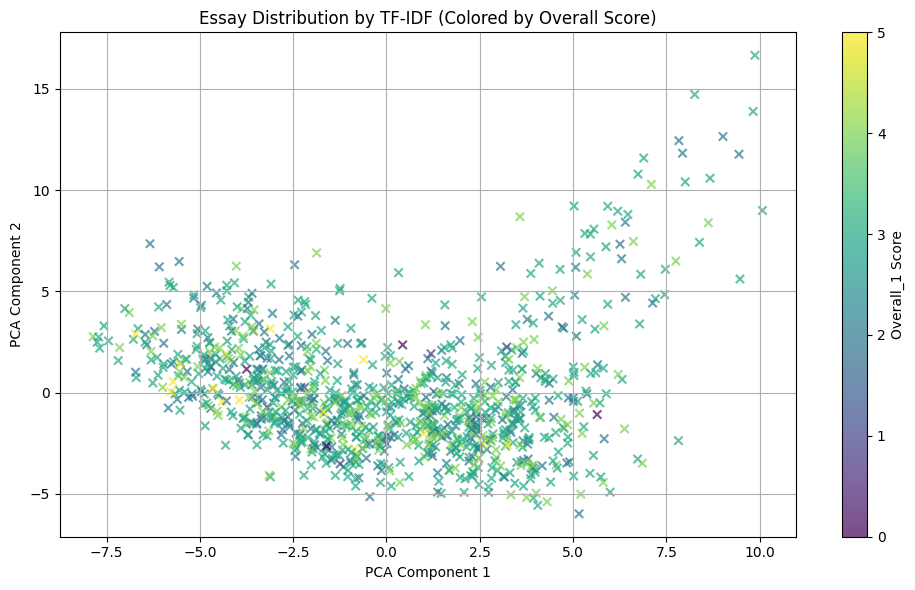

In [8]:
# Plot PCA result again, this time colored by Overall_1 score using "x" markers
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    sample_df['PCA1'], 
    sample_df['PCA2'], 
    c=sample_df['Overall_1'], 
    cmap='viridis', 
    alpha=0.7,
    marker='x'  # Use cross-shaped markers
)
plt.colorbar(scatter, label='Overall_1 Score')
plt.title("Essay Distribution by TF-IDF (Colored by Overall Score)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


PCA Visualization with Score Overlay
This plot presents the distribution of essays based on their TF-IDF representations, projected into 2D space using PCA. Each point represents an essay, and the color indicates the Overall_1 score:

Yellow/green points represent higher scores

Purple/dark points represent lower scores

Observations and Conclusions:
High-scoring essays (yellow-green) tend to cluster toward one side of the plot. This suggests that these essays share certain consistent features in lexical choice and structure.

Low-scoring essays (dark purple) are more widely and irregularly distributed, indicating greater variation in quality and inconsistency in writing style.

Overall, there appears to be a meaningful correlation between writing style and score, demonstrating that TF-IDF-based text representations can partially capture essay quality.

## Clustering Insights from Essay TF-IDF Analysis

### 1. Essays exhibit distinct clusters of writing styles
Using **TF-IDF vectors**, **KMeans clustering**, and **PCA visualization**, we observe that the essays can be effectively grouped into several clusters. Each cluster demonstrates **clear lexical distinctions**, reflecting unique writing patterns.

---

### 2. Clustering results correlate with proficiency scores (`Overall_1`)
- Clusters like **Cluster 2** and **Cluster 4** have **higher average scores**, indicating more structured writing with richer vocabulary and better grammar.
- **Cluster 0**, a lower-scoring group, tends to focus on school-related topics and likely features **simpler language and less complexity**.
- **High-scoring essays** are more **densely packed** in the PCA plot, while **low-scoring ones** are more **scattered**, showing wider stylistic variation.

---

### 3. Top keywords reveal stylistic and content differences
- **High-scoring clusters** frequently use **abstract and sophisticated vocabulary**, such as `success`, `failure`, `enthusiasm`, suggesting more reflective or argumentative writing.
- **Lower-scoring clusters** rely on **repetitive and basic vocabulary** like `school`, `students`, `time`, often presenting **factual descriptions with less depth or elaboration**.


2025-04-24 20:16:41.521544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745525801.716003      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745525801.769134      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

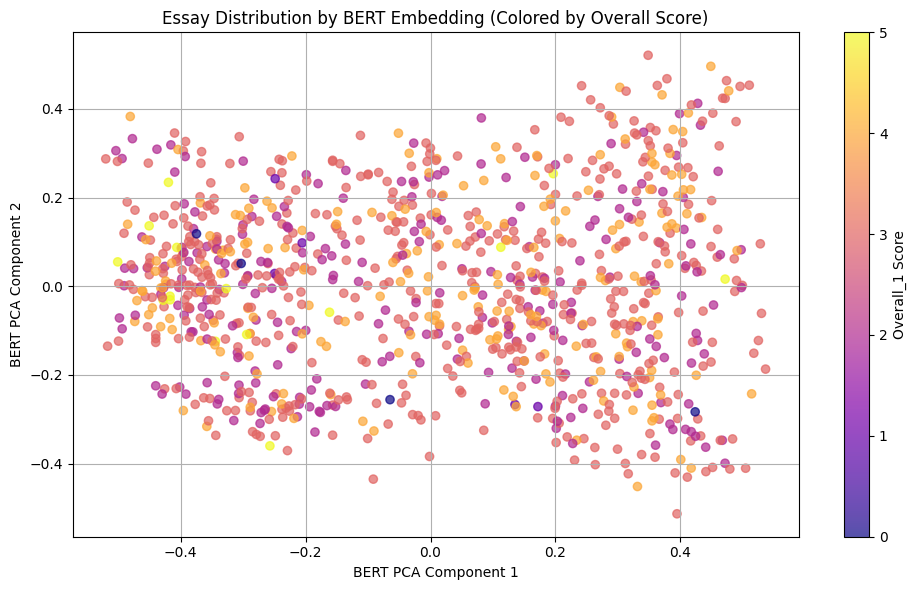

In [9]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Use a pretrained BERT sentence embedding model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the sampled texts into sentence embeddings
bert_embeddings = bert_model.encode(sample_df['Text'].tolist(), show_progress_bar=True)

# Reduce dimensions using PCA for visualization
pca_bert = PCA(n_components=2, random_state=42)
pca_bert_result = pca_bert.fit_transform(bert_embeddings)

# Add PCA result for plotting
sample_df['BERT_PCA1'] = pca_bert_result[:, 0]
sample_df['BERT_PCA2'] = pca_bert_result[:, 1]

# Plot BERT-based PCA result colored by score
plt.figure(figsize=(10, 6))
scatter = plt.scatter(sample_df['BERT_PCA1'], sample_df['BERT_PCA2'], c=sample_df['Overall_1'], cmap='plasma', alpha=0.7)
plt.colorbar(scatter, label='Overall_1 Score')
plt.title("Essay Distribution by BERT Embedding (Colored by Overall Score)")
plt.xlabel("BERT PCA Component 1")
plt.ylabel("BERT PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()